# Download OPERA-CSLCs from ASF and Generate Interferogram

## A Minimal Example

Based on OPERA_Applications notebook: [Create_Interferogram_by_Streaming_CSLC-S1](https://github.com/OPERA-Cal-Val/OPERA_Applications/blob/main/CSLC/Discover/Create_Interferogram_by_Streaming_CSLC-S1.ipynb)

In [1]:
from getpass import getpass
from pathlib import Path
import re

import h5py
import matplotlib.pyplot as plt
import numpy as np
import rasterio
from rasterio.crs import CRS
from rasterio.transform import from_origin
import shapely.wkt as wkt

import asf_search as disco

**Create a directory to hold the downloaded data**

In [2]:
data_dir = Path.cwd()/"OPERA_bursts"
data_dir.mkdir(exist_ok=True)

**Gather credentials for authentication with Earth Data Login**

In [3]:
username = input("Enter your EDL username")
password = getpass("Enter your EDL password")

Enter your EDL username aflewandowski
Enter your EDL password ········


**Start an asf_search session**

In [4]:
try:
    user_pass_session = disco.ASFSession().auth_with_creds(username, password)
except disco.ASFAuthenticationError as e:
    print(f'Auth failed: {e}')
else:
    print('Success!')

Success!


**Search and download data**

*Coming soon: Geographic Search with asf_search*

In [5]:
granule_list = [
    "OPERA_L2_CSLC-S1_T173-370304-IW2_20231018T134413Z_20231019T180049Z_S1A_VV_v1.0",
    "OPERA_L2_CSLC-S1_T173-370304-IW2_20231205T134412Z_20231206T075651Z_S1A_VV_v1.0"
    ]
results = disco.granule_search(granule_list)

for burst in results:
    burst.download(data_dir, session=user_pass_session)

**Collect the paths to the downloaded data**

In [6]:
bursts = list(data_dir.glob('*.h5'))
bursts.sort()
bursts

[PosixPath('/home/jovyan/OPERA_Play/OPERA_bursts/OPERA_L2_CSLC-S1_T173-370304-IW2_20231018T134413Z_20231019T180049Z_S1A_VV_v1.0.h5'),
 PosixPath('/home/jovyan/OPERA_Play/OPERA_bursts/OPERA_L2_CSLC-S1_T173-370304-IW2_20231205T134412Z_20231206T075651Z_S1A_VV_v1.0.h5')]

**Create a list of CSLC acquisition dates**

In [7]:
date_regex = r"\d{8}T\d{6}Z(?=_\d{8}T\d{6}Z)"
dates = []
try:
    for b in bursts:
        dates.append(re.search(date_regex, str(b)).group(0))
    dates = [d[:8] for d in dates]
    print(dates)  
except AttributeError:
    raise Exception(f"Date string not found in {b}") 

['20231018', '20231205']


**Generate the interferogram**

In [8]:
# Get the burst ID
burst_id_regex = r'(?<=OPERA_L2_CSLC-S1_)T\d{3}-\d{6}-IW\d'
try:
    burst_id = re.search(burst_id_regex, str(bursts[0])).group(0)
except AttributeError:
    raise Exception(f"Burst ID not found in {str(bursts[0])}") 

# Load the reference CSLC and gather needed metadata
with h5py.File(bursts[0], 'r') as h5:    
    grid_path = f'data'
    cslc_0 = h5[f'{grid_path}/VV'][:]    
    
    id_path = f'identification'
    bounding_polygon =h5[f'{id_path}/bounding_polygon'][()].astype(str) 
    cslc_poly = wkt.loads(bounding_polygon)
    bbox = [cslc_poly.bounds[0], cslc_poly.bounds[2], cslc_poly.bounds[1], cslc_poly.bounds[3]]
    
    xcoor = h5[f'{grid_path}/x_coordinates'][:]
    ycoor = h5[f'{grid_path}/y_coordinates'][:]    
    dx = h5[f'{grid_path}/x_spacing'][()].astype(int)
    dy = h5[f'{grid_path}/y_spacing'][()].astype(int)
    transform = from_origin(xcoor[0],ycoor[0],dx,np.abs(dy))
    epsg = h5[f'{grid_path}/projection'][()].astype(int)
    
# Load the secondary CSLC
with h5py.File(bursts[1], 'r') as h5:    
    grid_path = f'data'
    cslc_1 = h5[f'{grid_path}/VV'][:]

# Calculate interferogram
ifg = cslc_0 * np.conj(cslc_1)

**Plot the interferogram**

Text(0.5, 1.0, 'IFG_20231205-20231018_T173-370304-IW2')

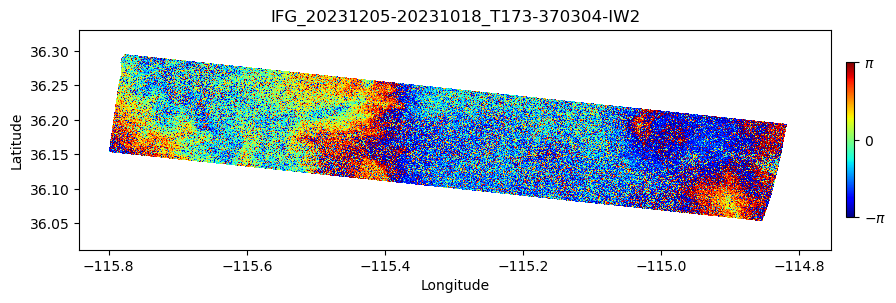

In [9]:
# Convert each pixel to RGB, adjusting colorscale relative to data range
def colorize(array=[], cmap='RdBu', cmin=[], cmax=[]):
    normed_data = (array - cmin) / (cmax - cmin)    
    cm = plt.cm.get_cmap(cmap)
    return cm(normed_data) 

# Plot each interferogram
fig, ax = plt.subplots(figsize=(10,3))
cax = ax.imshow(colorize(np.angle(ifg), 'jet', -np.pi, np.pi), cmap='jet',interpolation='nearest', origin='upper',extent=bbox, vmin=-np.pi, vmax=np.pi)
cbar = fig.colorbar(cax,orientation='vertical',fraction=0.01,pad=0.02)
cbar.set_ticks([-np.pi, 0., np.pi])
cbar.set_ticklabels([r'$-\pi$', '$0$', r'$\pi$'])
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
title = f'IFG_{dates[1]}-{dates[0]}_{burst_id}'
ax.set_title(title,fontsize=12)

**Write the interferogram to GeoTiff**

In [10]:
ifg_ang = np.angle(ifg)
ds = rasterio.open(f'{title}.tif', 'w', driver='GTiff',
                   height = ifg_ang.shape[0], 
                   width = ifg_ang.shape[1],
                   count=1, 
                   dtype=rasterio.float32,
                   crs=CRS.from_epsg(epsg),
                   transform=transform,nodata=np.nan)
ds.write(ifg_ang, 1)
ds.close()